# Simulated data
To illustrate some key points of the paper, generate data sampling from a multivariate normal distribution.
We sample from a 11-dimensional distribution, where all features have zero mean and unit variance, the first 10 (used as predictors in all the analyses we run) are orthogonal, and each of them has .2 correlation with the eleventh dimension (used as outcome). <br>
We simulate data iteratively, varyin the number of samples drawn. For each pass we fit OLS regression and cross-validated regression. <br> 
The purpose of these analyses is to illustrate the following points:
- **Increasing sample size** improves test performance and reduces risk of overfitting;
- For small sample sizes, we compare CV test R-squared and in-sample R-squared from OLS. CV test performance is a **more realistic estimate** of predictive performance and actual generalizability, while high in-sample R-squared is often an index of overfitting.

In [2]:
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_validate
import seaborn as sns
from matplotlib import pyplot as plt

## Set parameters for simulation
(There's no particular reason behind using these rather than other values. In terms of the two main points made in this notebook, other values should return a similar picture.)

In [3]:
nr_feat = 10
r = .2

In [4]:
cov_mat = np.eye(nr_feat)
cov_mat = np.vstack((cov_mat, [.2] * nr_feat))
cov_mat = np.hstack((cov_mat, np.array([.2] * nr_feat + [1]).reshape(-1,1)))

## Set up cross-validation and OLS

In [233]:
sizes = [int(s) for s in np.geomspace(50, 10000, 50)]
K = 10
est_lr = LinearRegression()
kfolds = KFold(n_splits=K)

## Generate data and fit models
Iterate through a list of sample sizes, simulate data, then fit OLS and CV models. <br>
We store in-sample **r-squared** for the OLS model, and mean **r-squared** across folds for both training and validation sets for cross-validated models. <br>

In [235]:
nr_sim = 100
avg_train, avg_test, avg_reg, confint_train, confint_test, confint_r2 = [], [], [], [], [], []

for idx, s in enumerate(sizes):
    print(idx)
    reg_r2, cv_r2_train, cv_r2_test = [], [], []    
    np.random.seed(n)

    for n in range(nr_sim):
        # Preprocess data
        data = np.random.multivariate_normal([0] * (nr_feat + 1), cov_mat, size=s)
        X_sub, y_sub = data[:,:nr_feat], data[:,nr_feat]
        X2 = sm.add_constant(X_sub)
        # Fit model
        est = sm.OLS(y_sub, X2)
        m = est.fit()
        reg_r2.append(m.rsquared)
        # Cross-validated model
        cv_scores = cross_validate(est_lr, X_sub, y_sub, cv=kfolds, 
                                return_train_score=True)
        cv_r2_test.append(cv_scores['test_score'].mean())
        cv_r2_train.append(cv_scores['train_score'].mean())

    avg_train.append(sum(cv_r2_train)/len(cv_r2_train))
    confint_train.append(np.quantile(cv_r2_train, q=[.025, .975]))
    avg_test.append(sum(cv_r2_test)/len(cv_r2_test))
    confint_test.append(np.quantile(cv_r2_test, q=[.025, .975]))
    avg_reg.append(sum(reg_r2) / len(reg_r2))
    confint_r2.append(np.quantile(reg_r2, q=[.025, .975]))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


## Training and test performance in CV by sample size
As sample size increases, test performance increases. Training performance decreases, converging towards test performance.
Increasing sample size reduces the risk of overfitting.

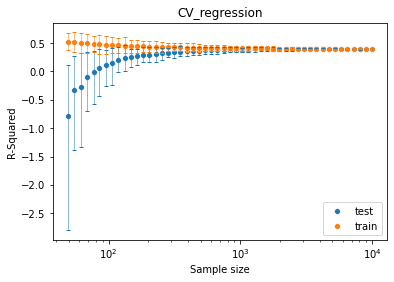

In [238]:
g = sns.scatterplot(sizes, avg_test, label='test')
g.errorbar(x=sizes, y=avg_test, yerr=abs(np.array(confint_test).T - avg_test), capsize=2, elinewidth=.5, ls='')
g2 = sns.scatterplot(sizes, avg_train, label='train')
g2.errorbar(x=sizes, y=avg_train, yerr=abs(np.array(confint_train).T - avg_train), capsize=2, elinewidth=.5, ls='')
plt.legend()
plt.xscale('log')
plt.xlabel('Sample size')
plt.ylabel('R-Squared')
plt.title('CV_regression')
plt.show()

## In-sample performance vs. test CV performance for small samples
For small samples, in-sample performance metrics from regression (overwhelmingly common metric of model performance in psychology) return an overly optimistic picture of actual performance and generalizability of the model. This is due to the fact that for small samples, the model tends to **overfit**. <br> On the contrary, cross-validated test performance yields lower and more realistic performance estimates, which helps calibrating inferences and claims made from the data and models.

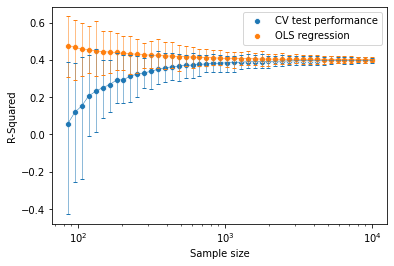

In [246]:
g = sns.scatterplot(sizes, avg_test, label='CV test performance')
g.errorbar(x=sizes, y=avg_test, yerr=abs(np.array(confint_test).T - avg_test), capsize=2, elinewidth=.5, linewidth=.5)
g2 = sns.scatterplot(sizes, avg_reg, label='OLS regression')
g2.errorbar(x=sizes, y=avg_reg, yerr=abs(np.array(confint_r2).T - avg_reg), capsize=2, elinewidth=.5, linewidth=.5)
plt.legend()
plt.xscale('log')
plt.xlabel('Sample size')
plt.ylabel('R-Squared')
plt.show()